<a href="https://colab.research.google.com/github/modichirag/flowpm/blob/u%2FEiffL%2Fops/notebooks/flowpm_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install git+https://github.com/modichirag/flowpm.git@u/EiffL/ops
# !git clone https://github.com/modichirag/flowpm.git 

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
%load_ext autoreload
%autoreload 2

In [26]:
%pylab inline
import tensorflow as tf
from scipy.interpolate import InterpolatedUnivariateSpline as iuspline
import importlib

# klin = np.loadtxt('./flowpm/data/Planck15_a1p00.txt').T[0]
# plin = np.loadtxt('./flowpm/data/Planck15_a1p00.txt').T[1]

# ipklin = iuspline(klin, plin)

Populating the interactive namespace from numpy and matplotlib


In [3]:
import sys
# sys.path.append('../../')
# sys.path.append('../')
# sys.path.append('./flowpm/')

# from flowpm import tfpm
# from flowpm import linear_field, lpt_init, nbody, cic_paint


In [9]:
import flowpm
# del flowpm
importlib.reload(flowpm)

bs = 100
nc = 63
batch_size = 1
stages = np.linspace(0.1, 1.0, 5, endpoint=True)
dtype = np.float32
Q = np.indices((nc, nc, nc)).reshape(3, -1).T.astype(dtype)
Q = np.repeat(Q.reshape((1, -1, 3)), batch_size, axis=0)

initial_conditions = flowpm.linear_field(nc,          # size of the cube
                                         bs,         # Physical size of the cube
                                         ipklin,      # Initial powerspectrum
                                         batch_size=batch_size)

lineark = flowpm.utils.r2c3d(initial_conditions)
icstate = flowpm.tfpm.lpt1(lineark, Q)
# Sample particles
state = flowpm.lpt_init(initial_conditions, a0=0.1)   

# # Evolve particles down to z=0
final_state = flowpm.nbody(state, stages, nc)         

# # Retrieve final density field
final_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), final_state[0])

with tf.Session() as sess:
    disp = sess.run(icstate)
    sim = sess.run(final_field)

In [10]:
# print(disp.std(axis=1))
# print(disp.shape)
print(disp)

[[[-0.4714585   4.0150104  -1.447598  ]
  [-0.72121394  4.7248516  -0.6338188 ]
  [-0.2692998   5.107969   -1.664031  ]
  ...
  [-0.5660394   1.5143672   0.20577526]
  [-0.5245319   2.020632   -1.8332813 ]
  [-0.222852    2.248567   -3.8046312 ]]]


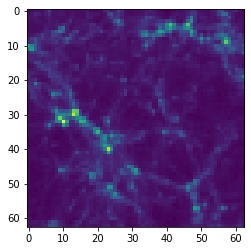

In [11]:
imshow(sim[0].sum(axis=0))

In [17]:
tf.__version__


'1.14.0'

In [13]:
import sys
sys.path.append('../code/utils/')
import tools

In [52]:
bs, nc = 100, 32
seed = 9220
num = int(1e-3 * bs**3)

ss = tools.readbigfile('/home/chmodi/Projects/cosmic-rim/data/make_data_code/L100-N32-B1-T5/S%d/mesh/s/'%seed)
dd0 = np.load('/home/chmodi/Projects/cosmic-rim/data/make_data_code/L100-N32-B1-T5/S%d/fpm-d.npy'%seed)

# pos = tools.readbigfile('/home/chmodi/Projects/cosmic-rim/data/L100-N32-B1-T5/S%d/dynamic/Position/'%seed)
# dd = tools.paintcic(pos, bs, nc)
dd = tools.readbigfile('/home/chmodi/Projects/cosmic-rim/data/make_data_code/L100-N32-B1-T5/S%d/mesh/d/'%seed)

# hpos = tools.readbigfile('/home/chmodi/Projects/cosmic-rim/data/L200-N256-B2-T10/S%d/fastpm_1.0000/LL-0.200/Position/'%seed)
hpos = tools.readbigfile('/home/chmodi/Projects/cosmic-rim/data/make_data_code/L100-N128-B2-T10/S%d/FOF/CMPosition/'%seed)
hh = tools.paintcic(hpos[:num], bs, nc)
hh /= hh.mean()
# hpos2 = tools.readbigfile('/home/chmodi/Projects/cosmic-rim/data/make_data_code/L100-N128-B2-T10/S%d/FOF/CMPosition/'%seed)
# hh2 = tools.paintcic(hpos2[:num], bs, nc)
# hh2 /= hh2.mean()


FileNotFoundError: [Errno 2] No such file or directory: '/home/chmodi/Projects/cosmic-rim/data/make_data_code/L100-N128-B2-T10/S9220/FOF/CMPosition/attr-v2'

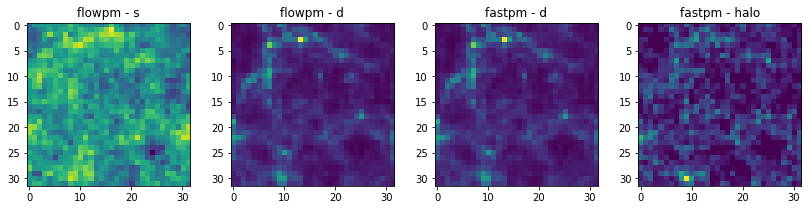

In [46]:
plt.figure(figsize = (14, 3))
plt.subplot(141)
plt.imshow(ss.sum(axis=0))
plt.title('flowpm - s')
plt.subplot(142)
plt.imshow(dd0.sum(axis=0))
plt.title('flowpm - d')
plt.subplot(143)
plt.imshow(dd.sum(axis=0))
plt.title('fastpm - d')
plt.subplot(144)
plt.imshow(hh.sum(axis=0))
plt.title('fastpm - halo')
plt.show()

In [49]:
# k, ph = tools.power(hh, boxsize=bs)
# k, ph2 = tools.power(hh2, boxsize=bs)
# k, pxhh = tools.power(hh, f2=hh2, boxsize=bs)

# plt.plot(k, ph/ph2,label='TF')
# plt.plot(k, pxhh/(ph*ph2)**0.5, label='r_c')
# plt.legend( fontsize=14)

# plt.semilogx()
# plt.ylim(0.5, 1.5)
# plt.grid(which='both')
# plt.xlabel('k (h/Mpc)', fontsize=14)

/home/chmodi/tflow14/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/home/chmodi/tflow14/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


Text(0.5, 0, 'k (h/Mpc)')

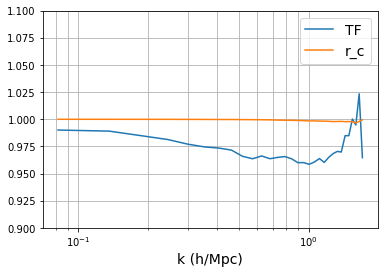

In [50]:
k, p0 = tools.power(dd0,  boxsize=bs)
k, pd = tools.power(dd,  boxsize=bs)
k, px0d = tools.power(dd0,  f2=dd, boxsize=bs)


plt.plot(k, p0/pd,label='TF')
plt.plot(k, px0d/(p0*pd)**0.5, label='r_c')
plt.legend( fontsize=14)

plt.semilogx()
plt.ylim(0.9, 1.1)
plt.grid(which='both')
plt.xlabel('k (h/Mpc)', fontsize=14)

/home/chmodi/tflow14/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/home/chmodi/tflow14/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


Text(0.5, 0, 'k (h/Mpc)')

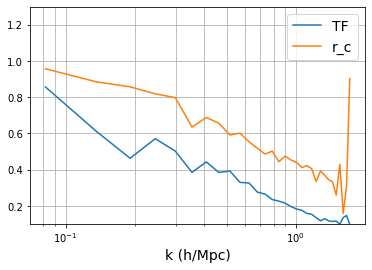

In [51]:
k, ph = tools.power(hh, boxsize=bs)
k, px0h = tools.power(dd0, f2=hh, boxsize=bs)
# k, px0h2 = tools.power(dd0, f2=hh2, boxsize=bs)
# 

plt.plot(k, p0/ph, 'C0', label='TF')
# plt.plot(k, p0/ph2, 'C0--', label='TF2')

plt.plot(k, px0h/(p0*ph)**0.5, 'C1', label='r_c')
# plt.plot(k, px0h2/(p0*ph2)**0.5, 'C1--', label='r_c2')
plt.legend( fontsize=14)

plt.semilogx()
plt.ylim(0.1, 1.3)
plt.grid(which='both')
plt.xlabel('k (h/Mpc)', fontsize=14)